In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import os

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import xarray as xr
from tools.plotting import plot_spectrum

DPI = 75
CMAP = "brg"
plt.rcParams["figure.figsize"] = (20, 9)
plt.style.use("default_light")

DATA1 = "/Users/nikola/work-brain/sleep_rhythms/results/20210125-pypet-AdEx_thalamus_feedback_-_AdEx_bifurcation_diagram_-_AdEx_noise/"
DATA2 = "/Users/nikola/work-brain/sleep_rhythms/results/20210201-pypet-AdEx_thalamus_feedback_-_AdEx_bifurcation_diagram_-_AdEx_no_noise/"


def norm_ou_mu(da):
    da["ou_exc_mu"] = da["ou_exc_mu"] / 5.0
    da["ou_inh_mu"] = da["ou_inh_mu"] / 5.0
    return da

In [2]:
da1 = xr.open_dataset(os.path.join(DATA1, "ts_slowLC.nc"))
da1 = da1.assign_coords({"aln_noise": 0.05}).expand_dims("aln_noise")

da2 = xr.open_dataset(os.path.join(DATA2, "ts_slowLC.nc"))
da2 = da2.assign_coords({"aln_noise": 0.0}).expand_dims("aln_noise")
ts = xr.combine_by_coords([da1, da2])

Effective window size : 2.560 (s)
Effective window size : 2.560 (s)
Effective window size : 2.560 (s)
Effective window size : 2.560 (s)
Effective window size : 2.560 (s)
Effective window size : 2.560 (s)
Effective window size : 2.560 (s)
Effective window size : 2.560 (s)
Effective window size : 2.560 (s)
Effective window size : 2.560 (s)
Effective window size : 2.560 (s)
Effective window size : 2.560 (s)
Effective window size : 2.560 (s)
Effective window size : 2.560 (s)
Effective window size : 2.560 (s)
Effective window size : 2.560 (s)
Effective window size : 2.560 (s)
Effective window size : 2.560 (s)
Effective window size : 2.560 (s)
Effective window size : 2.560 (s)
Effective window size : 2.560 (s)
Effective window size : 2.560 (s)
Effective window size : 2.560 (s)
Effective window size : 2.560 (s)


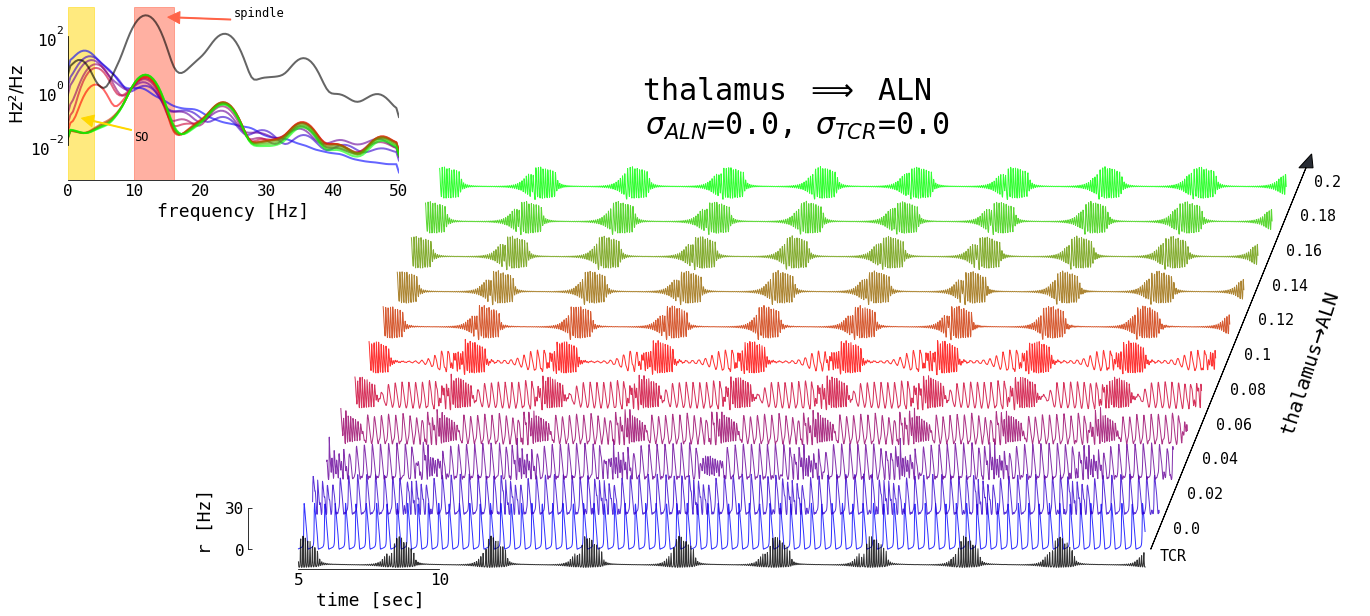

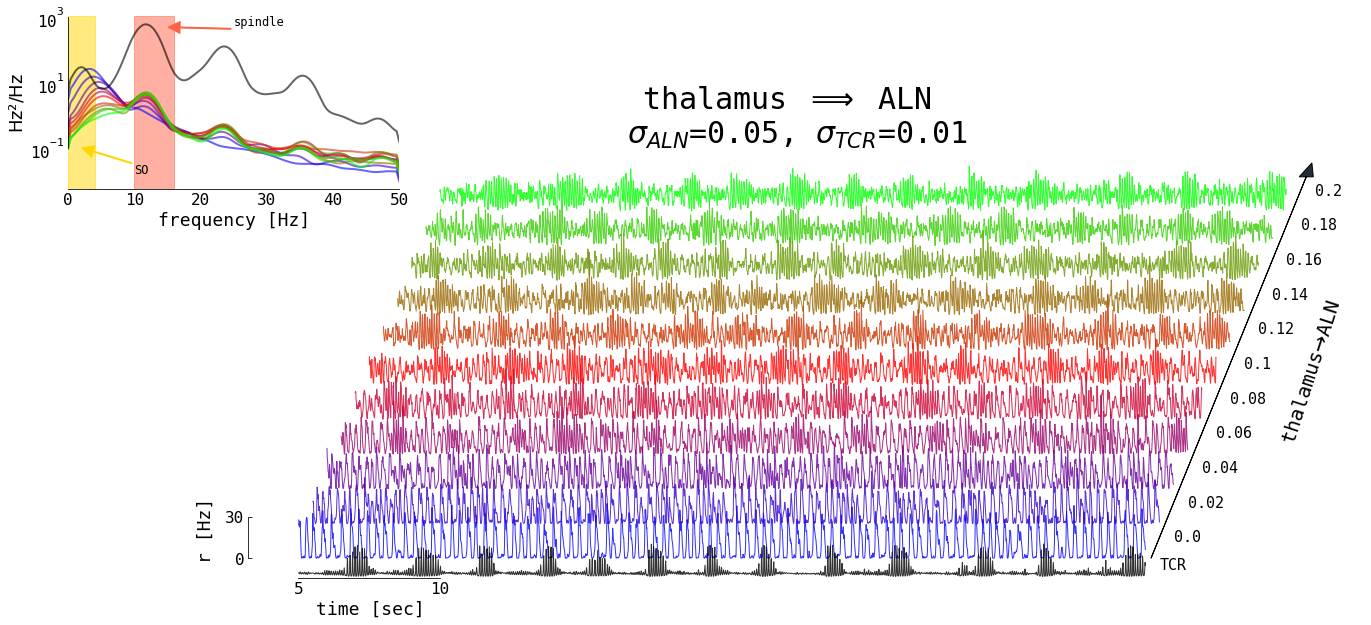

In [23]:
# thalamus -> ALN
params = [(0.0, 0.0), (0.01, 0.05)]

for tcr_n, aln_n in params:
    sels = {"tcr_noise": tcr_n, "aln_noise": aln_n, "AdEx-thalamus": 0.0, "node": 0.0}

    fig = plt.figure(figsize=(20, 8))
    colors = [
        plt.get_cmap(CMAP)(x) for x in np.linspace(0, 1, len(ts["thalamus-AdEx"]))
    ]
    df = pd.DataFrame(index=ts.time)

    # ALN timeseries
    for i, conn in enumerate(ts["thalamus-AdEx"]):
        ts_p = 1000 * ts.sel({**sels, "thalamus-AdEx": conn.values})["q_mean_EXC"]
        df[str(conn.values)] = ts_p
        plt.plot(
            ts.time + i * 0.5, ts_p + i * 25, color=colors[i], alpha=0.8, linewidth=1.0
        )
        plt.text(
            36 + i * 0.5, 15 + i * 25, f"{conn.values}", size=15, va="center", ha="left"
        )
    plt.gca().arrow(
        35.2,
        0,
        0.5 * len(ts["thalamus-AdEx"]),
        25 * len(ts["thalamus-AdEx"]),
        head_width=0.5,
        head_length=10,
    )
    plt.gca().text(
        37 + 0.5 * len(ts["thalamus-AdEx"]) / 2,
        25 * (len(ts["thalamus-AdEx"]) / 2 + 2),
        "thalamus$\\to$ALN",
        size=20,
        rotation=72,
        ha="left",
        va="top",
    )

    plt.gca().yaxis.set_major_locator(mpl.ticker.FixedLocator([0, 30]))
    plt.gca().yaxis.set_label_coords(-0.03, 0.11)
    plt.ylabel("r [Hz]")
    plt.gca().xaxis.set_major_locator(mpl.ticker.FixedLocator([5, 10]))
    plt.gca().xaxis.set_label_coords(0.11, -0.05)
    plt.xlabel("time [sec]")
    sns.despine(trim=True)

    # TCR timeseries
    ax2 = plt.gca().twinx()
    tcr = (
        ts.sel({**sels, "thalamus-AdEx": conn.values, "node": 1.0})["q_mean_EXC"] * 1000
    )
    df["TCR"] = tcr
    plt.plot(
        ts.time,
        tcr,
        color="k",
        alpha=0.8,
        linewidth=1.0,
    )
    ax2.set_ylim([0, 5000])
    ax2.axis("off")
    ax2.text(35.5, 150, "TCR", size=15, va="center", ha="left")

    # spectrum
    ax = fig.add_axes([0.0, 0.8, 0.23, 0.3])
    plot_spectrum(
        df,
        cmap=mpl.colors.ListedColormap(colors + [(0.0, 0.0, 0.0, 1.0)]),
        alpha=0.6,
        ax=ax,
        legend=False,
        units="Hz",
    )
    ax.grid(False)
    ax.set_xlabel("frequency [Hz]")
    sns.despine(ax=ax, trim=True)
    ax.axvspan(10, 16, alpha=0.5, color="tomato")
    ax.annotate(
        "spindle",
        xy=(15, 500),
        xytext=(25, 700),
        arrowprops=dict(fc="tomato", ec="tomato", shrink=0.01, width=1),
        fontsize=12,
        va="center",
    )
    ax.axvspan(0.01, 4, alpha=0.5, color="gold")
    ax.annotate(
        "SO",
        xy=(2, 0.1),
        xytext=(10, 0.02),
        arrowprops=dict(fc="gold", ec="gold", shrink=0.01, width=1),
        fontsize=12,
        va="center",
    )

    fig.suptitle(
        f"thalamus $\\Longrightarrow$ ALN \n $\\sigma_{{ALN}}$={aln_n}, "
        f"$\\sigma_{{TCR}}$={tcr_n}",
        size=30,
    )

    plt.savefig(
        f"../figs/loop_ts_thal_aln_aln_sig{aln_n}_tcr_sig{tcr_n}.pdf",
        dpi=DPI,
        bbox_inches="tight",
        transparent=True,
    )

Effective window size : 2.560 (s)
Effective window size : 2.560 (s)
Effective window size : 2.560 (s)
Effective window size : 2.560 (s)
Effective window size : 2.560 (s)
Effective window size : 2.560 (s)
Effective window size : 2.560 (s)
Effective window size : 2.560 (s)
Effective window size : 2.560 (s)
Effective window size : 2.560 (s)
Effective window size : 2.560 (s)
Effective window size : 2.560 (s)
Effective window size : 2.560 (s)
Effective window size : 2.560 (s)
Effective window size : 2.560 (s)
Effective window size : 2.560 (s)
Effective window size : 2.560 (s)
Effective window size : 2.560 (s)
Effective window size : 2.560 (s)
Effective window size : 2.560 (s)
Effective window size : 2.560 (s)
Effective window size : 2.560 (s)
Effective window size : 2.560 (s)
Effective window size : 2.560 (s)


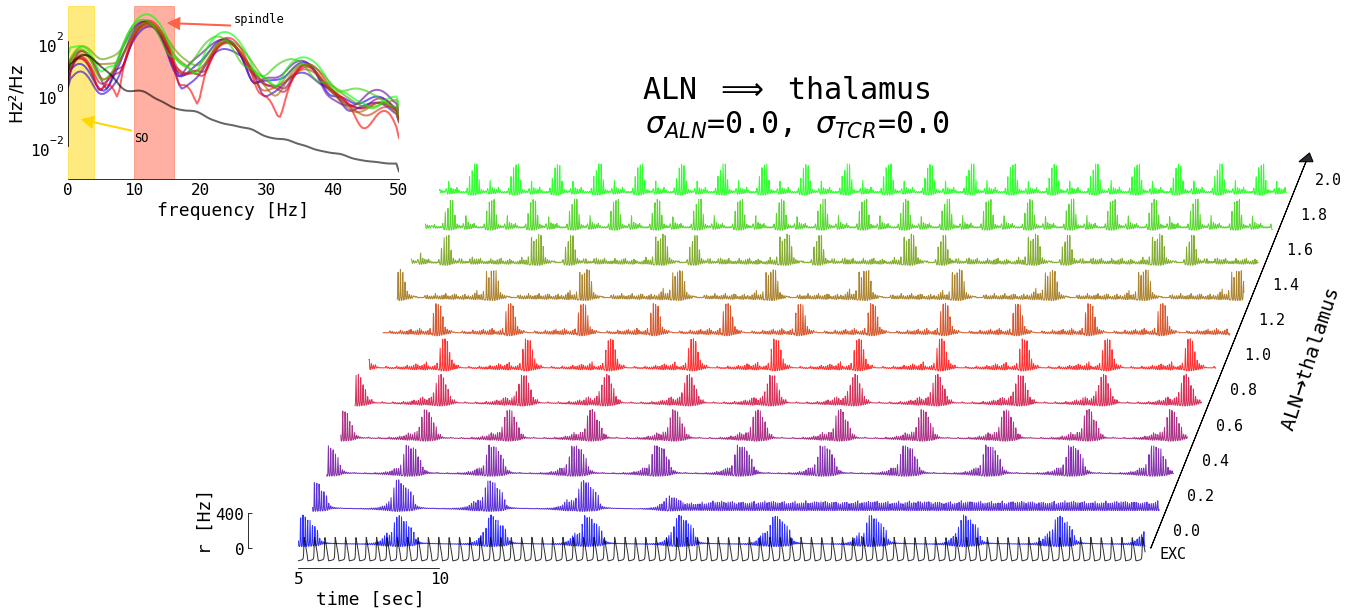

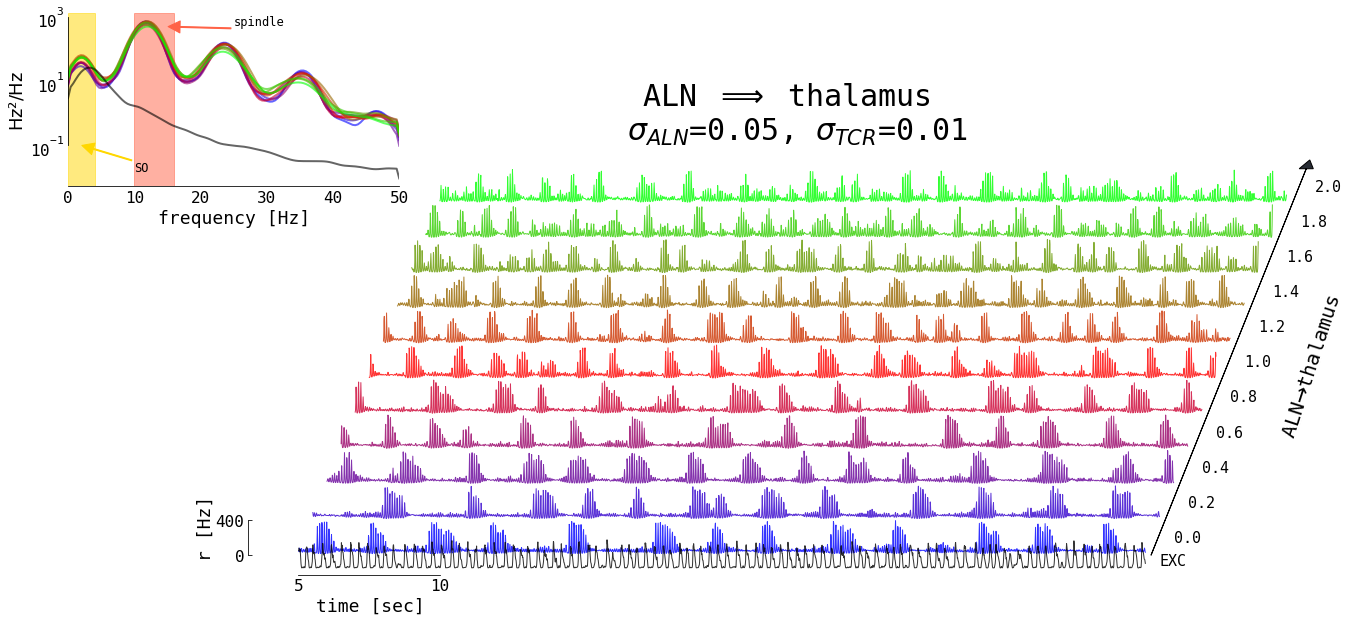

In [36]:
# ALN -> thalamus
params = [(0.0, 0.0), (0.01, 0.05)]

for tcr_n, aln_n in params:
    sels = {"tcr_noise": tcr_n, "aln_noise": aln_n, "thalamus-AdEx": 0.0, "node": 1.0}

    fig = plt.figure(figsize=(20, 8))
    colors = [
        plt.get_cmap(CMAP)(x) for x in np.linspace(0, 1, len(ts["AdEx-thalamus"]))
    ]
    df = pd.DataFrame(index=ts.time)

    # ALN timeseries
    for i, conn in enumerate(ts["AdEx-thalamus"]):
        ts_p = 1000 * ts.sel({**sels, "AdEx-thalamus": conn.values})["q_mean_EXC"]
        df[str(conn.values)] = ts_p
        plt.plot(
            ts.time + i * 0.5, ts_p + i * 400, color=colors[i], alpha=0.8, linewidth=1.0
        )
        plt.text(
            36 + i * 0.5, 200 + i * 400, f"{conn.values}", size=15, va="center", ha="left"
        )
    plt.gca().arrow(
        35.2,
        0,
        0.5 * len(ts["AdEx-thalamus"]),
        400 * len(ts["AdEx-thalamus"]),
        head_width=0.5,
        head_length=100,
    )
    plt.gca().text(
        37 + 0.5 * len(ts["AdEx-thalamus"]) / 2,
        400 * (len(ts["AdEx-thalamus"]) / 2 + 2),
        "ALN$\\to$thalamus",
        size=20,
        rotation=72,
        ha="left",
        va="top",
    )

    plt.gca().yaxis.set_major_locator(mpl.ticker.FixedLocator([0, 400]))
    plt.gca().yaxis.set_label_coords(-0.03, 0.11)
    plt.ylabel("r [Hz]")
    plt.gca().xaxis.set_major_locator(mpl.ticker.FixedLocator([5, 10]))
    plt.gca().xaxis.set_label_coords(0.11, -0.05)
    plt.xlabel("time [sec]")
    sns.despine(trim=True)

    # ALN timeseries
    ax2 = plt.gca().twinx()
    aln_e = (
        ts.sel({**sels, "AdEx-thalamus": 0.0, "node": 0.0})["q_mean_EXC"] * 1000
    )
    df["EXC"] = aln_e
    plt.plot(
        ts.time,
        aln_e,
        color="k",
        alpha=0.8,
        linewidth=1.0,
    )
    ax2.set_ylim([-10, 600])
    ax2.axis("off")
    ax2.text(35.5, 10, "EXC", size=15, va="center", ha="left")

    # spectrum
    ax = fig.add_axes([0.0, 0.8, 0.23, 0.3])
    plot_spectrum(
        df,
        cmap=mpl.colors.ListedColormap(colors + [(0.0, 0.0, 0.0, 1.0)]),
        alpha=0.6,
        ax=ax,
        legend=False,
        units="Hz",
    )
    ax.grid(False)
    ax.set_xlabel("frequency [Hz]")
    sns.despine(ax=ax, trim=True)
    ax.axvspan(10, 16, alpha=0.5, color="tomato")
    ax.annotate(
        "spindle",
        xy=(15, 500),
        xytext=(25, 700),
        arrowprops=dict(fc="tomato", ec="tomato", shrink=0.01, width=1),
        fontsize=12,
        va="center",
    )
    ax.axvspan(0.01, 4, alpha=0.5, color="gold")
    ax.annotate(
        "SO",
        xy=(2, 0.1),
        xytext=(10, 0.02),
        arrowprops=dict(fc="gold", ec="gold", shrink=0.01, width=1),
        fontsize=12,
        va="center",
    )

    fig.suptitle(
        f"ALN $\\Longrightarrow$ thalamus \n $\\sigma_{{ALN}}$={aln_n}, "
        f"$\\sigma_{{TCR}}$={tcr_n}",
        size=30,
    )

    plt.savefig(
        f"../figs/loop_ts_aln_thal_aln_sig{aln_n}_tcr_sig{tcr_n}.pdf",
        dpi=DPI,
        bbox_inches="tight",
        transparent=True,
    )